# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import glob
import shutil
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:259: SyntaxWarning: invalid escape sequence '\c'
  cbar_kwargs={'pad':0.03, 'shrink':0.5, 'label':'T [$^{\circ}$C]'})
/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:339: SyntaxWarning: invalid escape sequence '\c'
  cbar_kwargs = {'pad':0.03, 'shrink':0.5, 'label':'T [$^{\circ}$C]'}
/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [2]:
# Define geographical and temporal boundaries for data processing
# LON_LIMITS = (114, 116)
# LAT_LIMITS = (-33, -30.5)
LON_LIMITS = (114, 115.65)
LAT_LIMITS = (-33, -30.5)   
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2026-01-27T00:00:00", "2026-02-06T00:00:00"]
# time_lims = ["2026-01-30T00:00:00", "2026-01-30T10:00:00"]

crop_app = 'rottnest_rca26'

# # Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
# alldata_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'all')
# cropped_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'browse')
base_dir = os.path.join('/mnt', 'd', 'Work_backup', 'C_drive', 'Large_Data')
alldata_dir = os.path.join(base_dir, 'Other', 'Himawari', 'all')
cropped_dir = os.path.join(base_dir, 'Other', 'Himawari', crop_app)

##### Retrieve the required complete Himawari data files

Some files don't exist on the server. These timesteps will not get a velocity prediction.

In [3]:
# # Download the data
# himawari.get_sst_series_nasa(time_lims, alldata_dir)

In [4]:
# ### Crop himawari files (optional)

# # Setting ow=True will delete the original files after cropping (can also just set file_app='')
# himawari.crop_sst_series_nasa(alldata_dir, time_lims, ll_box, file_app=crop_app, overwrite=False)

In [5]:
# # Move the new files to another folder
# move_files = glob.glob(os.path.join(alldata_dir, f'*{crop_app}.nc'))
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     try:
#         shutil.move(mf, os.path.join(cropped_dir, f_name))
#     except:
#         print('Skipping file: {f_name}')

In [6]:
# # Load the data
# ds = himawari.process_sst_series(alldata_dir, time_lims, ll_box, file_app=crop_app, sst_reduce=2)
# ds

In [7]:
### Optional: save joined DS and delete individual cropped files
crop_app_mod = crop_app+'_4km'
# ds.to_netcdf(os.path.join(cropped_dir, f'{crop_app_mod}_compiled.nc'))
ds = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app_mod}_compiled.nc'))
ds = ds.sel(lat=slice(LAT_LIMITS[0]+0.6, LAT_LIMITS[1]-0.6), lon=slice(LON_LIMITS[0]+0.5, LON_LIMITS[1]))
ds

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 240, lat: 33, lon: 29)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2026-01-27 ... 2026-02-05T23:00:00
  * lat        (lat) float64 264B -32.38 -32.34 -32.3 ... -31.18 -31.14 -31.1
  * lon        (lon) float64 232B 114.5 114.5 114.6 114.6 ... 115.5 115.6 115.6
    LON        (lat, lon) float64 8kB ...
    LAT        (lat, lon) float64 8kB ...
    X          (lat, lon) float64 8kB ...
    Y          (lat, lon) float64 8kB ...
    lonc       float64 8B ...
    latc       float64 8B ...
    time_step  int64 8B ...
Data variables:
    T          (time, lat, lon) float64 2MB ...
    dTdt       (time, lat, lon) float64 2MB ...
    dTdx       (time, lat, lon) float64 2MB ...
    dTdy       (time, lat, lon) float64 2MB ...

In [8]:
# ani = plots.plot_data_animation(ds, anim_interval=100)
# ani.save(f'{crop_app_mod}_data_full.mp4')

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [9]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(59, 'm').astype('timedelta64[ns]')

# Set a mask - assume any points with all nan are invalid
mask = ~np.all(np.isnan(ds['T'].values), axis=0)

results_name = os.path.join(cropped_dir, f'{crop_app_mod}_fits_1h.nc')
# results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=results_name, callback='off', mask=mask, coverage=0.65)

Running GP optimization


In [10]:
# ds_results = xr.open_dataset(results_name)
# ds_results.close()
# ds_results

#### Make predictions using the inferred hyper-parameters

In [11]:
# print("Calculating GP regression prediction")
# ds_full = gpr.predict_series(ds.sel(time=ds_results.time), ds_results, mask=mask, coverage=0.65)
# ds_full.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app_mod}_predictions_1h.nc'))
# ds_full = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app_mod}_predictions_1h.nc'))
# ds_full

In [12]:
# fig, ax = plots.plot_param_series(ds_results, ds_full)

In [13]:
# ds_results = ds_results.dropna(dim='time')
# ds_results = utils.clean_dataset(ds_results)
# ds_results_hourly = utils.make_even_hourly(ds_results.copy())

# ds_full_hourly = utils.make_even_hourly(ds_full.copy())

In [14]:
def xarray_to_dict(ds):
    return {var: ds[var].values for var in ds.data_vars}

# ds_res_median = ds_results.isel(time=0).copy()
# for var in ds_res_median.data_vars:
#     ds_res_median[var].values = np.nanmedian(ds_results[var].values)
# ds_res_median.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_fits_1h_median.nc'))

ds_res_median = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_fits_1h_median.nc'))
ds_median_dict = xarray_to_dict(ds_res_median)

In [15]:
print("Calculating GP regression prediction")
# ds_predmedian = gpr.predict_series(ds, ds_median_dict, mask=mask, coverage=0.65)
# ds_predmedian.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app_mod}_predictions_1hmedian.nc'))
ds_predmedian = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app_mod}_predictions_1hmedian.nc'))

Calculating GP regression prediction


In [16]:
# def flag_step(ds, var='mu_u', std=3):
#     'Flag any step where the mean or std is much larger than the dataset standard deviation'
    
#     data_std = ds[var].std()
#     flag = np.full(len(ds.time.values), False)
    
#     for ii, tt in enumerate(ds.time.values):
#         step_mean = np.abs(ds[var].sel(time=tt)).mean()
#         step_std = ds[var].sel(time=tt).std()
#         if (step_mean > std*data_std) or (step_std > std*data_std):
#             flag[ii] = True

#     return flag

In [17]:
# med_flag = flag_step(ds_predmedian, var='mu_u', std=2)
# ds_predmedian = ds_predmedian.isel(time=~med_flag)

In [18]:
ds_predmedian_hr = utils.make_even_hourly(ds_predmedian.copy())

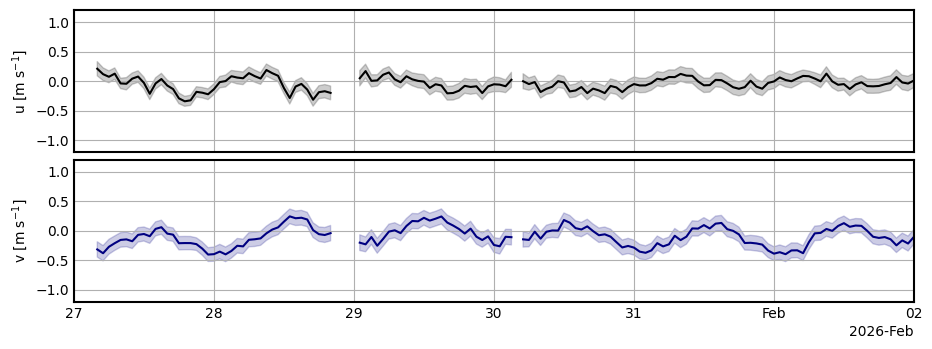

In [19]:
fig, ax = plots.plot_timeseries(ds_predmedian_hr, lon_pt=114.8, lat_pt=-31.75)
# ds_predmedian_hr['mu_u'].sel(lon=114.8, lat=-31.75, method='nearest').plot(ax=ax[0], c='r')
# ds_predmedian_hr['mu_v'].sel(lon=114.8, lat=-31.75, method='nearest').plot(ax=ax[1], c='r')
for x in ax:
    x.set_ylim(-1.21,1.21)
    x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[-1]) + np.timedelta64(-4,'D'))
    x.set_title('')

In [20]:
# fig, ax = plots.plot_timeseries(ds_predmedian_hr, lon_pt=115.415, lat_pt=-32.002)
# for x in ax:
#     x.set_ylim(-1.21,1.21)
#     # x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[-1]) + np.timedelta64(-4,'D'))

In [21]:
# pstp = -4
# fig, ax = plots.plot_prediction(ds_full_hourly.isel(time=pstp), qv_scale=10, qk_size=1.)
# print(ds_full_hourly.isel(time=pstp).time.values)

In [22]:
# fig, ax = plots.plot_prediction(ds_predmedian.isel(time=-1), qv_scale=10, qk_size=1.)

In [23]:
# ani = plots.plot_prediction_animation(ds_predmedian_hr, qv_scale=14, anim_interval=170)
# ani.save(f'{crop_app_mod}_animation_full.mp4')

## 24-hour average

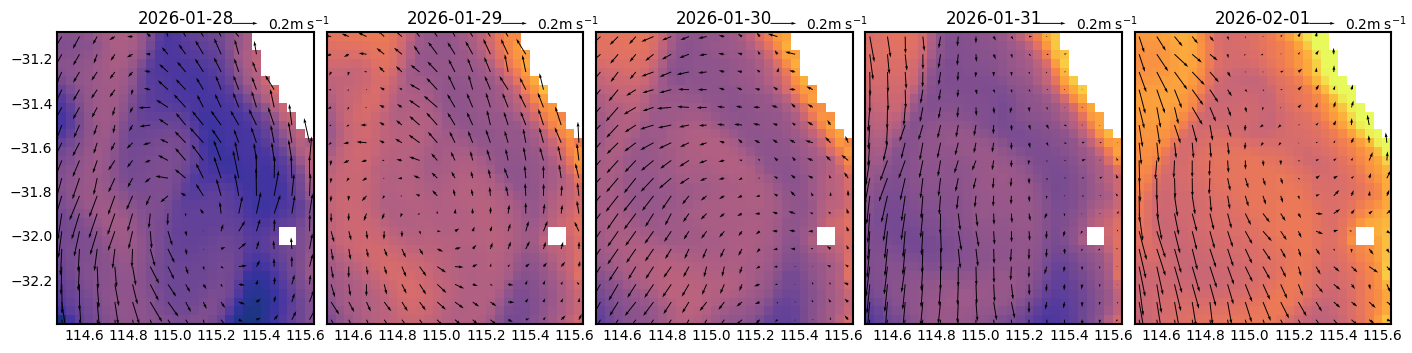

In [24]:
# Plot some 24-hour averages
p_days = np.arange(np.datetime64('2026-01-28'), np.datetime64('2026-02-02'), np.timedelta64(1,'D'))
fig, ax = plt.subplots(1, 5, figsize=(16, 4), gridspec_kw={'wspace':0.01})
for x, p_da in zip(ax, p_days):
    p_ds = ds_predmedian_hr.sel(time=slice(p_da, p_da + np.timedelta64(1,'D'))).mean(dim='time', skipna=True)
    plots.plot_scene(p_ds, ax=x, cbar=False, qv_scale=2, qk_size=0.2, vlims=(21.6,24.5), thin=2)
    x.set_title(str(p_da.astype('datetime64[D]')))
    if x != ax[0]:
        x.set_yticklabels([])

In [39]:
# ani = plots.plot_prediction_animation(ds_predmedian_hr, qv_scale=15, u_name='mu_u_lp', v_name='mu_v_lp', anim_interval=42)
# ani.save(f'{crop_app_mod}_animation_lp60hr.mp4')

In [40]:
ds_predmedian_hr

<xarray.Dataset> Size: 20MB
Dimensions:    (lon: 29, lat: 33, time: 233)
Coordinates:
  * lon        (lon) float64 232B 114.5 114.5 114.6 114.6 ... 115.5 115.6 115.6
  * lat        (lat) float64 264B -32.38 -32.34 -32.3 ... -31.18 -31.14 -31.1
  * time       (time) datetime64[ns] 2kB 2026-01-27T04:00:00 ... 2026-02-05T2...
    LON        (lat, lon) float64 8kB 114.5 114.5 114.6 ... 115.5 115.6 115.6
    LAT        (lat, lon) float64 8kB -32.38 -32.38 -32.38 ... -31.1 -31.1 -31.1
    X          (lat, lon) float64 8kB -3.011e+04 -2.635e+04 ... 7.632e+04
    Y          (lat, lon) float64 8kB -6.875e+04 -6.875e+04 ... 7.318e+04
    lonc       float64 8B 114.8
    latc       float64 8B -31.76
    time_step  int64 8B 3600
Data variables:
    T          (time, lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
    dTdt       (time, lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
    dTdx       (time, lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
    dTdy       (time, lat, lon) float64 2MB nan nan nan nan ... nan nan nan nan
    mu_u       (time, lat, lon) float64 2MB 0.1476 0.1424 0.1372 ... nan nan nan
    mu_v       (time, lat, lon) float64 2MB -0.6547 -0.6283 -0.6017 ... nan nan
    mu_S       (time, lat, lon) float64 2MB 3.063e-05 3.073e-05 ... nan nan
    std_u      (time, lat, lon) float64 2MB 0.1678 0.1653 0.1628 ... nan nan nan
    std_v      (time, lat, lon) float64 2MB 0.1821 0.1787 0.1754 ... nan nan nan
    std_S      (time, lat, lon) float64 2MB 8.076e-06 7.889e-06 ... nan nan
    K_uv       (time, lat, lon) float64 2MB 8.127e-06 6.906e-05 ... nan nan

## Particle tracking

In [50]:
import numpy as np
from geographiclib.geodesic import Geodesic
from scipy.interpolate import LinearNDInterpolator

def simulate_particle_flow_field_timeseries(X, Y, u, v, lon0, lat0, lonc, latc, tstep, N):

    # flatten data
    Xf = X.flatten()
    Yf = Y.flatten()
    
    # allocate
    lons = np.empty([N])
    lats = np.empty([N])

    x0 = np.sign(lon0-lonc)*Geodesic.WGS84.Inverse(lat0,lon0,lat0,lonc)['s12']
    y0 = np.sign(lat0-latc)*Geodesic.WGS84.Inverse(lat0,lon0,latc,lon0)['s12']    
    
    lons[0], lats[0] = (lon0, lat0)
    xp, yp = (x0, y0)
    
    for uf, vf, ii in zip(u, v, range(1,N)):
        uf = uf.flatten()
        vf = vf.flatten()

        # define the interpolation function
        interp_u = LinearNDInterpolator(list(zip(Xf, Yf)), uf)
        interp_v = LinearNDInterpolator(list(zip(Xf, Yf)), vf)

        up = interp_u(xp, yp).item()
        vp = interp_v(xp, yp).item()

        # update locations
        xp += up*tstep
        yp += vp*tstep

        geo_dict = Geodesic.WGS84.Direct(latc, lonc, np.rad2deg(np.arctan2(xp, yp)), np.sqrt(xp**2 + yp**2))

        lons[ii] = geo_dict['lon2']
        lats[ii] = geo_dict['lat2']

    return lons, lats

In [78]:
from inversion_sst_gp.simulation.particle_tracking import simulate_particle_flow_field

lon_pt = 115.415
lat_pt = -32.002

lons_all = []
lats_all = []

p_days = np.arange(np.datetime64('2026-01-30'), np.datetime64('2026-02-02'), np.timedelta64(1,'h'))

for p_da in p_days:
    ds_sim = ds_predmedian_hr.sel(time=slice(p_da, None))

    lons, lats = simulate_particle_flow_field_timeseries(
            ds_sim['X'].values,
            ds_sim['Y'].values,
            ds_sim['mu_u'].values,
            ds_sim['mu_v'].values,
            lon_pt,
            lat_pt,
            lon_pt,
            lat_pt,
            3600,
            24*4)
    
    lons_all.append(lons)
    lats_all.append(lats)

(-32.2, -31.5)

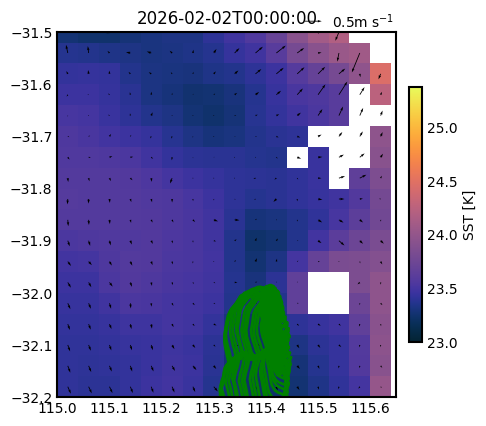

In [79]:
# Plot some 24-hour averages
ax = plots.plot_scene(ds_sim.sel(time=np.datetime64('2026-02-02')), qv_scale=10, qk_size=0.5)
for lons, lats in zip(lons_all, lats_all):
    ax.plot(lons, lats, c='g', lw=2)
ax.scatter(lons[0], lats[0], c='w')
ax.set_xlim(115, 115.65)
ax.set_ylim(-32.2, -31.5)

In [99]:
lons_all = []
lats_all = []

p_days = np.arange(np.datetime64('2026-02-01'), np.datetime64('2026-02-07'), np.timedelta64(6,'h'))

for p_da in p_days:
    ds_sim = ds_predmedian_hr.sel(time=slice(p_da, None))

    lons, lats = simulate_particle_flow_field_timeseries(
            ds_sim['X'].values,
            ds_sim['Y'].values,
            ds_sim['mu_u'].values,
            ds_sim['mu_v'].values,
            lon_pt,
            lat_pt,
            lon_pt,
            lat_pt,
            3600,
            24*4)
    
    lons_all.append(lons)
    lats_all.append(lats)

(-32.2, -31.5)

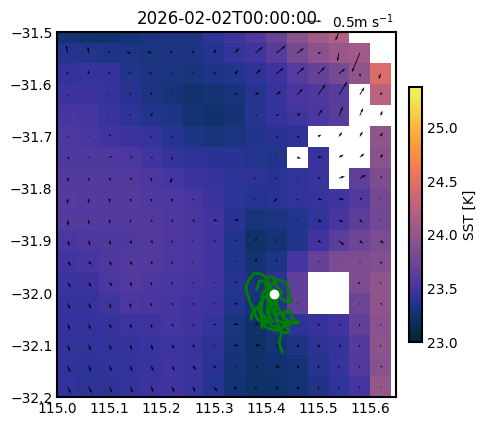

In [100]:
# Plot some 24-hour averages
ax = plots.plot_scene(ds_predmedian_hr.sel(time=np.datetime64('2026-02-02')), qv_scale=10, qk_size=0.5)
for lons, lats in zip(lons_all, lats_all):
    ll_x = (lons > 115) & (lats < -31)
    ax.plot(lons[ll_x], lats[ll_x], c='g', lw=2)
ax.scatter(lons[0], lats[0], c='w', zorder=10)
ax.set_xlim(115, 115.65)
ax.set_ylim(-32.2, -31.5)